# Telecom Customer Churn
This dataset comes from an Iranian telecom company, with each row representing a customer over a year period. Along with a churn label, there is information on the customers' activity, such as call failures and subscription length. 

Not sure where to begin? Scroll to the bottom to find challenges!

In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler


from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

df = pd.read_csv("data/customer_churn.csv")
print(df.shape)
df.head(100)





(3150, 14)


,Call Failure,Complaints,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,19,0,19,2,6453,144,90,44,2,2,1,25,701.865,0
96,15,0,17,1,8993,174,78,42,5,1,1,55,254.505,0
97,11,0,18,4,2913,48,36,21,3,1,1,30,262.440,0
98,5,0,11,2,4450,43,220,12,3,1,1,30,1059.720,0


## Data Dictionary
| Column                  | Explanation                                             |
|-------------------------|---------------------------------------------------------|
| Call Failure            | number of call failures                                 |
| Complaints              | binary (0: No complaint, 1: complaint)                  |
| Subscription Length     | total months of subscription                            |
| Charge Amount           | ordinal attribute (0: lowest amount, 9: highest amount) |
| Seconds of Use          | total seconds of calls                                  |
| Frequency of use        | total number of calls                                   |
| Frequency of SMS        | total number of text messages                           |
| Distinct Called Numbers | total number of distinct phone calls                    |
| Age Group               | ordinal attribute (1: younger age, 5: older age)        |
| Tariff Plan             | binary (1: Pay as you go, 2: contractual)               |
| Status                  | binary (1: active, 2: non-active)                       |
| Age                     | age of customer                                         |
| Customer Value          | the calculated value of customer                        |
| Churn                   | class label (1: churn, 0: non-churn)                    |

[Source](https://www.kaggle.com/royjafari/customer-churn)  of dataset and [source](https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset) of dataset description. 

**Citation**: Jafari-Marandi, R., Denton, J., Idris, A., Smith, B. K., & Keramati, A. (2020). Optimum Profit-Driven Churn Decision Making: Innovative Artificial Neural Networks in Telecom Industry. Neural Computing and Applications.

## Don't know where to start?

**Challenges are brief tasks designed to help you practice specific skills:**

- 🗺️ **Explore**: Which age groups send more SMS messages than make phone calls?
- 📊 **Visualize**: Create a plot visualizing the number of distinct phone calls by age group. Within the chart, differentiate between short, medium, and long calls (by the number of seconds).
- 🔎 **Analyze**: Are there significant differences between the length of phone calls between different tariff plans?

**Scenarios are broader questions to help you develop an end-to-end project for your portfolio:**

You have just been hired by a telecom company. A competitor has recently entered the market and is offering an attractive plan to new customers. The telecom company is worried that this competitor may start attracting its customers.

You have access to a dataset of the company's customers, including whether customers churned. The telecom company wants to know whether you can use this data to predict whether a customer will churn. They also want to know what factors increase the probability that a customer churns.

You will need to prepare a report that is accessible to a broad audience. It should outline your motivation, steps, findings, and conclusions.

In [129]:
df.isna().sum()

Call Failure               0
Complaints                 0
Subscription Length        0
Charge Amount              0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64

In [130]:
# Which age groups send more SMS messages than make phone calls?
age_groups = df.groupby('Age Group')

avg_sms = age_groups['Frequency of SMS'].mean()
avg_call = age_groups['Frequency of use'].mean()
more_sms = avg_sms > avg_call
print(more_sms)



Age Group
1    False
2     True
3     True
4    False
5    False
dtype: bool


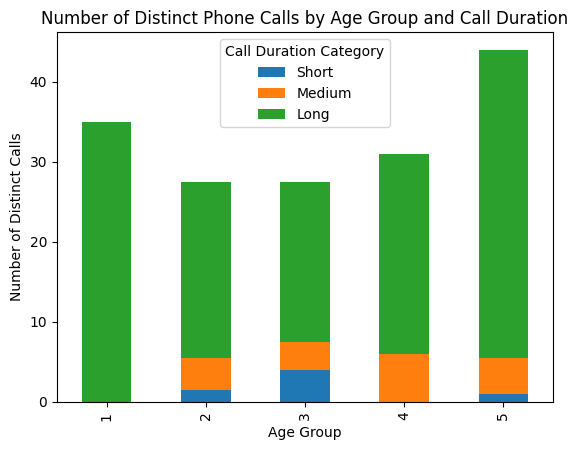

In [131]:

# Group the data by age group and calculate the mean number of distinct called numbers
distinct_calls_by_age = df.groupby('Age Group')['Distinct Called Numbers'].mean()

# Create a new column to categorize the calls as short, medium, or long based on the number of seconds
df['Call Duration Category'] = pd.cut(df['Seconds of Use'], bins=[0, 60, 300, float('inf')], labels=['Short', 'Medium', 'Long'])

# Group the data by age group and call duration category, and calculate the count of distinct calls
distinct_calls_by_age_duration = df.groupby(['Age Group', 'Call Duration Category'])['Distinct Called Numbers'].median()

# Reshape the data to have age groups as rows and call duration categories as columns
distinct_calls_by_age_duration = distinct_calls_by_age_duration.unstack()

# Plot the data
distinct_calls_by_age_duration.plot(kind='bar', stacked=True)

# Set the labels and title
plt.xlabel('Age Group')
plt.ylabel('Number of Distinct Calls')
plt.title('Number of Distinct Phone Calls by Age Group and Call Duration')

# Show the plot
plt.show()

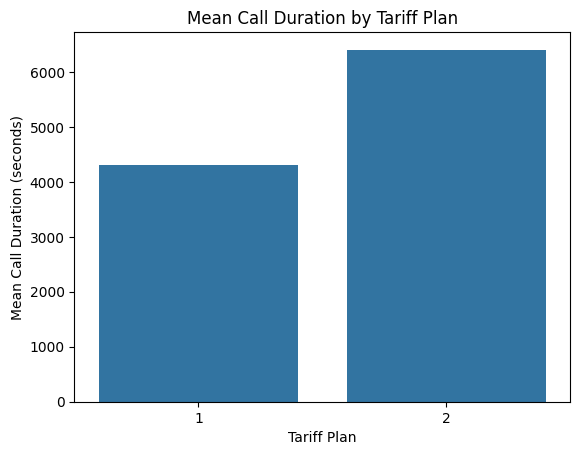

In [132]:

# Group the data by tariff plan and calculate the mean call duration
mean_call_duration_by_tariff = df.groupby('Tariff Plan')['Seconds of Use'].mean()

# Plot the mean call duration for each tariff plan
sns.barplot(x=mean_call_duration_by_tariff.index, y=mean_call_duration_by_tariff.values)

# Set the labels and title
plt.xlabel('Tariff Plan')
plt.ylabel('Mean Call Duration (seconds)')
plt.title('Mean Call Duration by Tariff Plan')

# Show the plot
plt.show()



In [133]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    
check_df(df)

##################### Shape #####################
(3150, 15)
##################### Types #####################
Call Failure                  int64
Complaints                    int64
Subscription Length           int64
Charge Amount                 int64
Seconds of Use                int64
Frequency of use              int64
Frequency of SMS              int64
Distinct Called Numbers       int64
Age Group                     int64
Tariff Plan                   int64
Status                        int64
Age                           int64
Customer Value              float64
Churn                         int64
Call Duration Category     category
dtype: object
##################### Head #####################
   Call Failure  Complaints  ...  Churn  Call Duration Category
0             8           0  ...      0                    Long
1             0           0  ...      0                    Long
2            10           0  ...      0                    Long
3            10           0  .

In [134]:

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
     Note: Categorical variables with numerical appearance are also included.

     parameters
     ------
         dataframe: dataframe
                 Dataframe from which variable names are to be taken
         cat_th: int, optional
                 Class threshold value for variables that are numeric but categorical
         car_th: int, optinal
                 class threshold for categorical but cardinal variables

     returns
     ------
         cat_cols: list
                 Categorical variable list
         num_cols: list
                 Numerical variable list
         cat_but_car: list
                 List of cardinal variables with categorical view

     examples
     ------
         import seaborn as sns
         df = sns.load_dataset("iris")
         print(grab_col_names(df))


     Notes
     ------
         cat_cols + num_cols + cat_but_car = total number of variables
         num_but_cat is inside cat_cols.
         The sum of the 3 lists that return equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


In [135]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)



In [136]:
# checking the categorical cols
for col in cat_cols:
    cat_summary(df, col)

   Complaints      Ratio
0        2909  92.349206
1         241   7.650794
##########################################
   Tariff Plan      Ratio
1         2905  92.222222
2          245   7.777778
##########################################
   Status      Ratio
1    2368  75.174603
2     782  24.825397
##########################################
   Churn      Ratio
0   2655  84.285714
1    495  15.714286
##########################################
        Call Duration Category      Ratio
Long                      2950  93.650794
Medium                      41   1.301587
Short                        5   0.158730
##########################################


In [137]:
# checking the numerical cols
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Call Failure,3150.0,7.627937,7.263886,0.0,1.00000,6.00,12.00000,36.00
Subscription Length,3150.0,32.541905,8.573482,3.0,30.00000,35.00,38.00000,47.00
Charge Amount,3150.0,0.942857,1.521072,0.0,0.00000,0.00,1.00000,10.00
Seconds of Use,3150.0,4472.459683,4197.908687,0.0,1391.25000,2990.00,6478.25000,17090.00
Frequency of use,3150.0,69.460635,57.413308,0.0,27.00000,54.00,95.00000,255.00
Frequency of SMS,3150.0,73.174921,112.237560,0.0,6.00000,21.00,87.00000,522.00
Distinct Called Numbers,3150.0,23.509841,17.217337,0.0,10.00000,21.00,34.00000,97.00
Age Group,3150.0,2.826032,0.892555,1.0,2.00000,3.00,3.00000,5.00
Age,3150.0,30.998413,8.831095,15.0,25.00000,30.00,30.00000,55.00
Customer Value,3150.0,470.972916,517.015433,0.0,113.80125,228.48,788.38875,2165.28


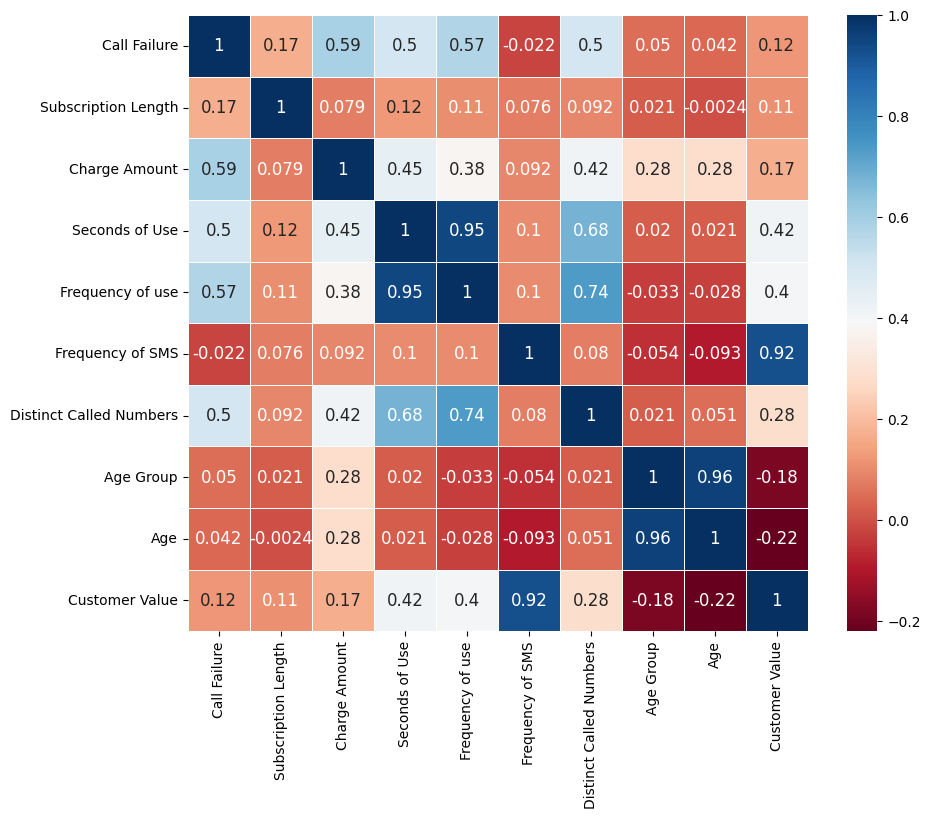

In [138]:
# correlation in numerical variables

correlation_matrix(df, num_cols)


In [139]:
for col in num_cols:
    target_summary_with_num(df, "Churn", col)

       Call Failure
Churn              
0          7.656121
1          7.476768


       Subscription Length
Churn                     
0                32.662524
1                31.894949


       Charge Amount
Churn               
0           1.075706
1           0.230303


       Seconds of Use
Churn                
0         5014.224105
1         1566.632323


       Frequency of use
Churn                  
0             76.979284
1             29.133333


       Frequency of SMS
Churn                  
0             83.871563
1             15.802020


       Distinct Called Numbers
Churn                         
0                    25.582674
1                    12.391919


       Age Group
Churn           
0       2.831638
1       2.795960


             Age
Churn           
0      31.065913
1      30.636364


       Customer Value
Churn                
0          535.511501
1          124.811414




In [140]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


In [141]:
# 

df.loc[(df['Age'] < 30), "NEW_AGE_CAT"] = 'young'
df.loc[(df['Age'] >= 30) & (df['Age'] <= 46), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df['Age'] > 46), "NEW_AGE_CAT"] = 'old'

df.head()


,Call Failure,Complaints,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn,Call Duration Category,NEW_AGE_CAT
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0,Long,middleage
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0,Long,young
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0,Long,middleage
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0,Long,young
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0,Long,young


In [215]:
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

Call Failure False
Subscription Length False
Charge Amount False
Seconds of Use False
Frequency of use False
Frequency of SMS False
Distinct Called Numbers False
Age Group False
Age False
Customer Value False


In [143]:
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

In [144]:
y = df["Churn"]
X_Scaled = df.drop(["Churn"], axis=1)

X_Test, X_Train, y_test, y_train = train_test_split(X,y, test_size=0.3)


def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

base_models(X, y, scoring="accuracy")



Base Models....
accuracy: 0.8571 (LR) 
accuracy: 0.8235 (KNN) 
accuracy: 0.8429 (SVC) 
accuracy: 0.926 (CART) 
accuracy: 0.9441 (RF) 
accuracy: 0.9156 (Adaboost) 
accuracy: 0.9283 (GBM) 
accuracy: 0.9467 (XGBoost) 
accuracy: 0.9467 (LightGBM) 


In [214]:
X.columns
random_user = X.sample(1, random_state=45)
voting_clf.predict(random_user)

array([1])